Visualize learned TRF coefficients.

In [1]:
from argparse import ArgumentParser, Namespace
from collections import defaultdict
from copy import deepcopy
from itertools import product
from pathlib import Path
import pickle
import sys

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import clone
import torch
from tqdm.auto import tqdm, trange

In [2]:
from IPython.display import HTML

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append(str(Path(".").resolve().parent.parent))
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.eeg import load_eeg_dataset
import berp.models.reindexing_regression as rr
from berp.viz.trf import trf_to_dataframe, plot_trf_coefficients

In [5]:
IS_INTERACTIVE = False
try:
    get_ipython()  # type: ignore
except NameError: pass
else: IS_INTERACTIVE = True
IS_INTERACTIVE

True

In [6]:
p = ArgumentParser()
p.add_argument("model_base_dir", type=Path, nargs="+")
p.add_argument("subjects", type=str, nargs="+")
p.add_argument("stories", type=str, nargs="+")
p.add_argument("run_names", type=str, nargs="+")

_StoreAction(option_strings=[], dest='run_names', nargs='+', const=None, default=None, type=<class 'str'>, choices=None, required=True, help=None, metavar=None)

In [18]:
if IS_INTERACTIVE:
    args = Namespace(
        # model_base_dir=Path("../../work/6a/13acff29799f3c1dc2122961c28d9b"),
        # model_base_dir=Path("../../work/2b/cda8e6c76a9235517148309c3afb33/"),
        model_base_dir=Path("../../work/a0/090a725e038a2820a9bbaf079e95a9/"),
        subjects=["avg"],
        stories=["DKZ_1", "DKZ_2"],
        run_names=["berp-fixed-withlambda4"],)
else:
    args = p.parse_args()

## Load results

In [19]:
# Load pipelines.
if len(args.run_names) > 1:
    raise NotImplementedError("not yet supporting multiple pipelines")

pipes = []
for run in args.run_names:
    pipeline_path = args.model_base_dir / run / "params" / "pipeline.pkl"
    if not pipeline_path.exists():
        print(f"Missing pipeline at {pipeline_path}")

    with pipeline_path.open("rb") as f:
        pipes.append(pickle.load(f))
        
    # TODO shape checks etc.

# TODO support more than one pipeline
pipe = pipes[0]

In [20]:
# Load datasets.
target_sensors = ["C1", "Cz", "C2", "CP1", "CPz", "CP2"]
ds = {}
combs = list(product(args.stories, args.subjects))
for story, subject in tqdm(combs):
    ds_path = args.model_base_dir / f"average_dataset.{story}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue

    ds[story, subject] = load_eeg_dataset(
        [ds_path], "biosemi64", subset_sensors=target_sensors,
        normalize_X_ts=True, normalize_X_variable=True, normalize_Y=True).datasets[0]

  0%|          | 0/2 [00:00<?, ?it/s]

## Preprocessing

In [21]:
encoders = {subject: pipe.encoders_[subject] for subject in args.subjects}

In [22]:
sample_ds = next(iter(ds.values()))
feature_names = sample_ds.ts_feature_names + sample_ds.variable_feature_names
feature_names

['binned acoustical edges >100Hz_0',
 'binned acoustical edges >100Hz_1',
 'binned acoustical edges >100Hz_2',
 'binned acoustical edges >100Hz_3',
 'binned acoustical edges >100Hz_4',
 'binned acoustical edges >100Hz_5',
 'binned acoustical edges >100Hz_6',
 'binned acoustical edges >100Hz_7',
 'phoneme entropy_0',
 'phoneme onsets_0',
 'phoneme surprisal_0',
 'binned spectrogram >100Hz_0',
 'binned spectrogram >100Hz_1',
 'binned spectrogram >100Hz_2',
 'binned spectrogram >100Hz_3',
 'binned spectrogram >100Hz_4',
 'binned spectrogram >100Hz_5',
 'binned spectrogram >100Hz_6',
 'binned spectrogram >100Hz_7',
 'word onsets_0',
 'recognition_onset',
 'word_frequency',
 'word_surprisal']

In [23]:
coef_df = pd.concat({
    subject: trf_to_dataframe(encoder, feature_names)
    for subject, encoder in encoders.items()
}, names=["subject", "x"])

In [24]:
coef_df

feature  lag  sensor      coef  epoch_time  \
subject x                                                   
avg     0            0    0       0  0.006022      0.0000   
        1            0    0       1  0.007383      0.0000   
        2            0    0       2  0.007378      0.0000   
        3            0    0       3  0.005424      0.0000   
        4            0    0       4  0.006798      0.0000   
...                ...  ...     ...       ...         ...   
        10069       22   72       1  0.000670      0.5625   
        10070       22   72       2  0.000340      0.5625   
        10071       22   72       3  0.000945      0.5625   
        10072       22   72       4  0.000765      0.5625   
        10073       22   72       5  0.000171      0.5625   

                                   feature_name  
subject x                                        
avg     0      binned acoustical edges >100Hz_0  
        1      binned acoustical edges >100Hz_0  
        2      binned acoustical edges >100Hz_0  
        3      binned acoustical edges >100Hz_0  
        4      binned acoustical edges >100Hz_0  
...                                         ...  
        10069                    word_surprisal  
        10070                    word_surprisal  
        10071                    word_surprisal  
        10072                    word_surprisal  
        10073                    word_surprisal  

[10074 rows x 6 columns]

In [25]:
coef_df.feature_name.unique()

array(['binned acoustical edges >100Hz_0',
       'binned acoustical edges >100Hz_1',
       'binned acoustical edges >100Hz_2',
       'binned acoustical edges >100Hz_3',
       'binned acoustical edges >100Hz_4',
       'binned acoustical edges >100Hz_5',
       'binned acoustical edges >100Hz_6',
       'binned acoustical edges >100Hz_7', 'phoneme entropy_0',
       'phoneme onsets_0', 'phoneme surprisal_0',
       'binned spectrogram >100Hz_0', 'binned spectrogram >100Hz_1',
       'binned spectrogram >100Hz_2', 'binned spectrogram >100Hz_3',
       'binned spectrogram >100Hz_4', 'binned spectrogram >100Hz_5',
       'binned spectrogram >100Hz_6', 'binned spectrogram >100Hz_7',
       'word onsets_0', 'recognition_onset', 'word_frequency',
       'word_surprisal'], dtype=object)

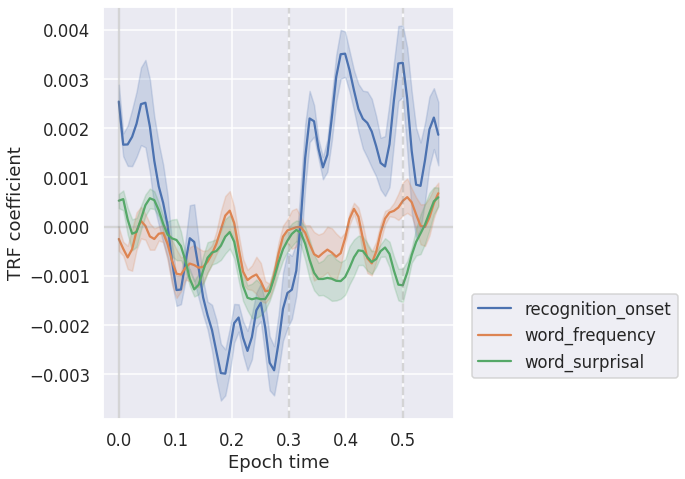

In [26]:
plt.figure(figsize=(10, 7))
plot_trf_coefficients(coef_df, feature_match_patterns=["word_surprisal", "word_frequency",
                                                       "recognition_onset"])
None

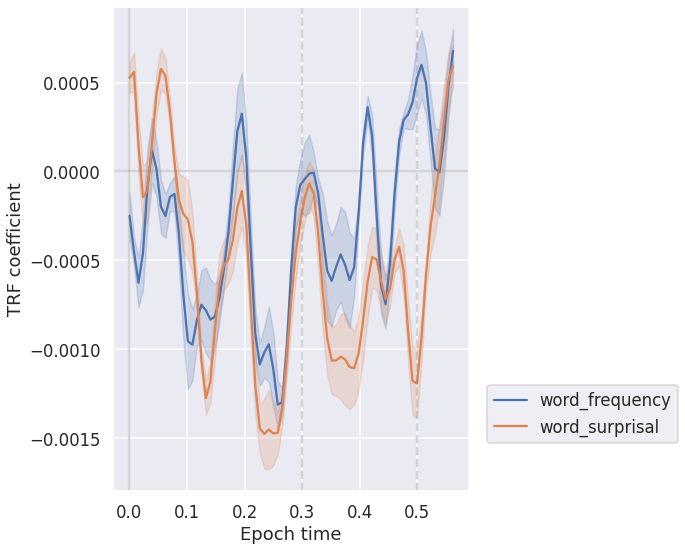

In [27]:
sns.set("talk")
plt.figure(figsize=(10, 8))
plot_trf_coefficients(coef_df, feature_match_patterns=["word_surprisal", "word_frequency"], errorbar="se")
None

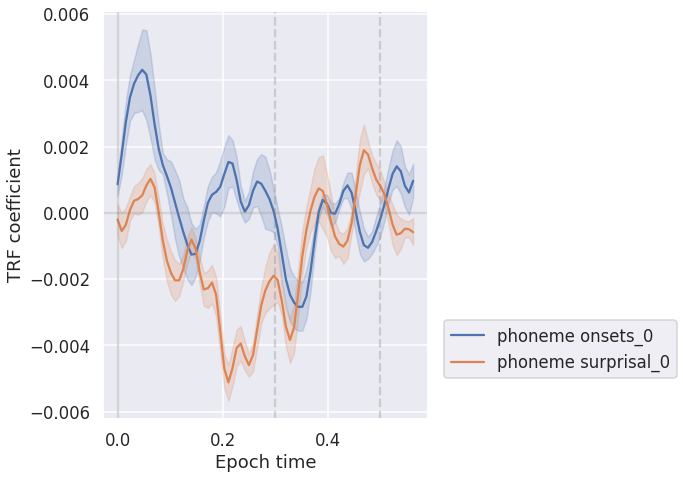

In [28]:
plt.figure(figsize=(10, 7))
plot_trf_coefficients(coef_df, feature_match_patterns=["phoneme onset", "phoneme surprisal", "cohort"])
None